<a href="https://colab.research.google.com/github/Apmaranca/NCMnaST/blob/gh-pages/PyTorch_uintopressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch method for tranform Lung pressure to uin fft


My first idea for approaching the problem posed in Google Brain - Ventilator Pressure Prediction was to find a way to circunvent the problem of trying to solve a tipical dynamic problem with static models, not time dependent. As I have a past in thermodynamics, it's natural to think about this ventilating system as a series of ordinary differential equations on pressure, evolving on time. 
To make things worst, the data set showed many series of pressure along time as independent values. That's exactly whats what we should do for a database, but it's very strange for a dynamical system. 
Thinking about the real problem of ventilating, we must know what pressure to apply on each moment, but it's not true that we don't know the entire pressure curve. We know the points until that moment and certainly it's not much to ask a first breath to calibrate the respirator, since it could get all the dymamical characteristics of the lung. 
If we approach the lung as a live functional lung, there as air entering the lung in the inspiration and there is no pressure increase in the lung, since it gets bigger exactly to make the air enter. 
Once we have a respirator, we pressupose some effort in letting the air in, that we could think divided in two energy expenditures. One elastic and one plastic deformation of the lung, using these terms losely, just to indicate that one fraction will be elastic, like a rubber ballon, ans will exert some work expanding, like a expanding spring, obeying a two dimmentional Hooke Law, that won't be very easy to model, but certainly have a dynamic character. This elastic work will be used to expel the air plus carbon dioxide out of the lungs. 
Another part of the energy used in the inspiration will be used to expand the lungs inelastic and may not be recovered in the expiration, neither will be described by any two dimmensional Hooke law. 
Anyway, for a physical model, there will be a very complex and dynamical model.
Since we don't see any preocupation in controling a low pressure outlet for the expiration, we pressupose that the elastic fraction of the lungs expansion is dominant and just the inspiration is critical.  
### From de dynamical lung behavior to the Fast Fourier Transform
If one analises all the given pressure curves in the inspiration, we perceive that there are several types of typical behavior. This is state even in the competition description. There are several types of lungs, ages, sizes and elastic coeficients that results in very different curves. 
This was largely explored by the coleagues in clusterings of the curves. 
I don't think, however, that it's adequated to cluster the curves per se, the pressure along time curves, but its dynamical characteristics. 
Not all the dynamical characteristics was though as relevant too. We used a fast Fourier Transform to get all the frequencies from this pressure curves but we declared interest just in the low and medium frequency range. There are a lot of oscilations and vibrations of high frequency that we considered to be irrelevant for the ventilation, just catch frequencies of the order of tenths of minutes or less. Zero frequency, os constant pressure, is not of interest too. 
We buit this model here: https://www.kaggle.com/alfredomaranca/lightautoml-fft-powered-for-the-respirator as a first step for this approach. 

### How to use this fft approach

There is a caveat in this approach for one to use it in this competition, since in the test data we don't have a pressure dinamics of the lungs, just the uin curve. We should have a curve of pressure for another respirator cycle of the same lung, but we have just uin data. 
The uin data, however, translates very well the dynamics of the pressure of the lung and there a good correlation of pressure fft and uin fft. 
Since we are data science freaks, let us translate uin fft for this lung (that we have) to pressure fft. Once given a data set, we get the entire uin curve, calculate it's fft and use this neural network to evaluate a pressure fft curve, that could be used in the model. 
In this notebook we present this fft transformation. 

### What is to be made. 

We need, now, to translate the test data using this neural network and incrementing the model with the low and medium frequencies that characterise the dynamical response of the lungs.
I'm not sure I'll have time to do this, since I have another duties and spent already much time on this, but you are welcome to try and share the results. 


In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
import pandas as pd
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader , TensorDataset

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
images_pd = pd.read_csv('/content/drive/MyDrive/kaggle/input/ventilator-pressure-prediction/uin_sign.csv')
labels_pd = pd.read_csv('/content/drive/MyDrive/kaggle/input/ventilator-pressure-prediction/pressure_sign.csv')
X = images_pd[images_pd.sum(axis=1) != 0]
y = labels_pd[labels_pd.sum(axis=1) != 0]
results_to_learn = X.shape[0]
tmpX = torch.tensor(X.values.astype(np.float32))
tmpy = torch.tensor(y.values.astype(np.float32)) #dtype=torch.long, device=device
dataset = TensorDataset(tmpX , tmpy)
trainloader = DataLoader(dataset , shuffle=True) #batch_size = 16, desactivated
#testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [5]:
y


,0,1,2,3,4,5
1,1.000000,0.408682,0.258872,0.148300,0.089062,0.058699
2,1.000000,0.289840,0.142355,0.114043,0.071609,0.049044
3,0.972773,0.958388,1.000000,0.372466,0.226257,0.011190
4,1.000000,0.484864,0.120219,0.033307,0.012502,0.021616
5,1.000000,0.213998,0.105382,0.086002,0.040437,0.034681
6,1.000000,0.904156,0.524202,0.235788,0.116240,0.042056
7,0.330925,1.000000,0.120792,0.004581,0.059932,0.072586
9,1.000000,0.315690,0.122006,0.107037,0.072876,0.034781
10,1.000000,0.936061,0.588108,0.348418,0.108830,0.045605
12,0.140950,0.078140,0.145025,0.376780,0.201388,0.885130


In [6]:
trainloader


In [7]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(6, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,6)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

In [8]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)

- The only change we have made to the code is that we are going to track the training loss, the testing loss and the accuracy across the 30 epochs.
- We'll print out the train loss, the test loss and the accuracy after each epoch.
- Because we are running this over 30 epochs this will take a bit longer to run - approx 15 minutes.

In [9]:
from torch import optim
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3000
train_tracker, test_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    cum_loss = 0
    
    for batch, (images, labels) in enumerate(trainloader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        #print(output)
        #print(labels)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
    
    train_tracker.append(cum_loss/len(trainloader))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(trainloader)} | ",end='')
    
    test_loss = 0
    num_correct = 0
    total = 0
    
    

Epoch(1/3000) | Training loss: 2.122975394839332 | Epoch(2/3000) | Training loss: 2.1224980439458574 | Epoch(3/3000) | Training loss: 2.1221636675653004 | Epoch(4/3000) | Training loss: 2.121930102507273 | Epoch(5/3000) | Training loss: 2.1217665331704274 | Epoch(6/3000) | Training loss: 2.1216505765914917 | Epoch(7/3000) | Training loss: 2.1215680156435286 | Epoch(8/3000) | Training loss: 2.1215092710086276 | Epoch(9/3000) | Training loss: 2.121467351913452 | Epoch(10/3000) | Training loss: 2.121437191963196 | Epoch(11/3000) | Training loss: 2.121415300028665 | Epoch(12/3000) | Training loss: 2.1213991869063604 | Epoch(13/3000) | Training loss: 2.121387322743734 | Epoch(14/3000) | Training loss: 2.12137838772365 | Epoch(15/3000) | Training loss: 2.121371473584856 | Epoch(16/3000) | Training loss: 2.12136618580137 | Epoch(17/3000) | Training loss: 2.121361928326743 | Epoch(18/3000) | Training loss: 2.1213584599040805 | Epoch(19/3000) | Training loss: 2.121355584689549 | Epoch(20/3000) 

- Has the accuracy of the model increased?
- Now plot the training loss vs the test loss over 30 epochs.

UsageError: Line magic function `%plt.plot` not found.


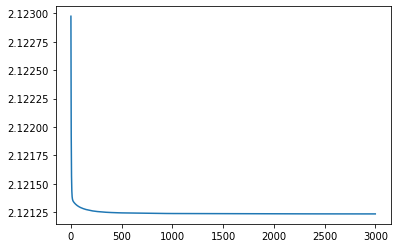

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
%plt.plot(test_tracker, label='Test loss')
plt.legend()

- Now add the accuracy to the mix.

UsageError: Line magic function `%plt.plot` not found.


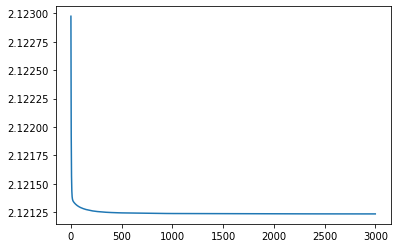

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
%plt.plot(test_tracker, label='Test loss')
%plt.plot(accuracy_tracker, label='Test accuracy')
plt.legend()

## Further challenges and experiments
- Can you get better accuracy from a model if you :
    - Add more layers?
    - Change the number of nodes in the layers?
    - Train over fewer/higher epochs?
    
- Can you improve on your results if you add additional layers like [Dropout](https://pytorch.org/docs/master/nn.html#torch.nn.Dropout)

In [12]:
output = open("uin2pressure", mode="wb")
torch.save(model.state_dict(), output)